In [66]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib
import sklearn
from sklearn_pandas import DataFrameMapper
from functools import partial
matplotlib.style.use('ggplot')
%matplotlib inline

In [67]:
df = pd.read_csv('edata.csv')
del df['Region']
df = df.iloc[::-1]

In [68]:
train_test_ratio = .8
train_size = int(df.shape[0] * train_test_ratio)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
cross_val_size = test_data.shape[0]//2
cross_val_data = test_data.iloc[:cross_val_size]
test_data = test_data.iloc[cross_val_size:]

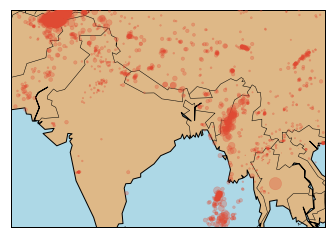

/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [69]:
def plot_earthquakes(data):
    m = Basemap(projection='mill',llcrnrlat=9.800,urcrnrlat=37.720, llcrnrlon=64.510,urcrnrlon=107.580,resolution='c')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='burlywood',lake_color='lightblue', zorder = 1)
    m.drawmapboundary(fill_color='lightblue')
    x, y= m(list(data['Lon']), list(data['Lat']))
    m.scatter(x, y, s = data['Mag']*data['Depth km']*0.1, marker='o', alpha=0.3, zorder=10, cmap = 'coolwarm')
plot_earthquakes(cross_val_data)

In [70]:
scaler = partial(sklearn.preprocessing.MinMaxScaler, (-1, 1))
magscaler = scaler()
latscaler = scaler()
lonscaler = scaler()
depthscaler = scaler()
timescaler = scaler()
mapper = DataFrameMapper([
       # (['Region'], None),
        (['Mag'],magscaler),
        (['Lat'],latscaler),
        (['Lon'],lonscaler),
        (['Depth km'],depthscaler),
        (['Timestamp'], timescaler) 
    ],default = None)
train_data = mapper.fit_transform(train_data)
#train_data[['Mag','Lat','Lon','Timestamp','Depth km']] = train_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)
test_data = mapper.transform(test_data)[:-1]
cross_val_data = mapper.transform(cross_val_data)
#test_data[['Mag','Lat','Lon','Timestamp','Depth km']] = test_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)


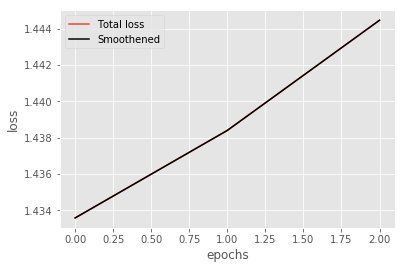

lr decreased to 0.125
Epoch 2 avg. batch loss 1.44446


lr decreased to 0.25
Epoch 1 avg. batch loss 1.4384


lr decreased to 0.5
Epoch 0 avg. batch loss 1.43358


Training set loss:


In [110]:
num_epochs = 3 
truncated_backprop_length = 15
state_size = 10  # num hidden units
echo_step = -3
batch_size = 4 # must be a factor of train data and test data size
total_series_length, num_features = train_data.shape
num_outputs = num_features
num_batches = total_series_length - (total_series_length//batch_size*(batch_size-1) + truncated_backprop_length-1)
num_layers = 2  # num hidden layers
learning_rate_decay = .8

x = train_data
y = np.roll(x, echo_step,axis=0)
y[echo_step:] = np.zeros(num_features)
x = x.reshape((batch_size, -1, num_features))
y = y.reshape((batch_size, -1, num_features))

def prepareNoBatches(data):
    x = data
    y = np.roll(x, echo_step, 0)
    y[echo_step:] = np.zeros(num_features)
    x = np.vstack([np.expand_dims(x, 0), np.zeros((3, x.shape[0], 5))])
    y = np.vstack([np.expand_dims(y, 0), np.zeros((3, y.shape[0], 5))])
    return x, y

xtest, ytest = prepareNoBatches(test_data)
xcross, ycross = prepareNoBatches(cross_val_data)

total_series_length, _ = test_data.shape
num_batches_test = total_series_length - (total_series_length//batch_size*(batch_size-1) + truncated_backprop_length-1)

graph = tf.Graph()
with graph.as_default():

    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, None, num_features])
    batchY_placeholder = tf.placeholder(tf.float32, [batch_size, None, num_features])

    keep_prob = tf.placeholder(tf.float32)
    init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

    state_per_layer_list = tf.unstack(init_state, axis=0)
    rnn_tuple_state = tuple([tf.contrib.rnn.core_rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
                   for idx in range(num_layers)])

    W = tf.Variable(np.random.rand(state_size+num_features, state_size), dtype=tf.float32)
    b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

    W2 = tf.Variable(np.random.rand(state_size, num_outputs),dtype=tf.float32)
    b2 = tf.Variable(np.zeros((1,num_outputs)), dtype=tf.float32)

    # Forward passes
    cell = tf.contrib.rnn.core_rnn_cell.LSTMCell(state_size, state_is_tuple=True)
    cell = tf.contrib.rnn.core_rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    cell = tf.contrib.rnn.core_rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
 
    states_series, current_state = tf.nn.dynamic_rnn(cell, batchX_placeholder, initial_state=rnn_tuple_state)
    states_series = tf.reshape(states_series, [-1, state_size])

    outputs = tf.matmul(states_series, W2) + b2
    targets = tf.reshape(batchY_placeholder, [-1, num_features])

    losses = tf.sqrt(tf.reduce_mean(tf.squared_difference(outputs, targets),0))
    total_loss = tf.reduce_sum(losses)
    step = tf.Variable(0, trainable=False)
    learning_rate = tf.placeholder(tf.float32)
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

batchesX = []
batchesY = []
for batch_idx in range(num_batches):
    start_idx = batch_idx
    end_idx = start_idx + truncated_backprop_length

    batchesX.append(x[:, start_idx:end_idx])
    batchesY.append(y[:, start_idx:end_idx])
            
loss_list = []
lr = 1
test_outputs = None 
test_targets = None
cross_outputs = None
cross_targets = None
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Training set loss:')
    for epoch_idx in range(num_epochs):

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))
        batch_loss = [] 
        for batch_idx in range(num_batches):

            _total_loss, _train_step, _current_state = sess.run(
                [total_loss, train_step, current_state],
                feed_dict={
                    batchX_placeholder: batchesX[batch_idx],
                    batchY_placeholder: batchesY[batch_idx],
                    init_state: _current_state,
                    keep_prob: 0.8,
                    learning_rate: lr
                })
            batch_loss.append(_total_loss) 
            
        loss_list.append(np.mean(batch_loss))
        if np.argmin(loss_list[-2:]) == 0:
            lr *= learning_rate_decay
            print('lr decreased to', lr)
        if lr < .00001:
            num_epochs = epoch_idx + 1
            break
        if epoch_idx % 1 == 0:
            print("Epoch", epoch_idx, "avg. batch loss", np.mean(batch_loss)) 
    
    _current_state = np.zeros((num_layers, 2, batch_size, state_size))
    
    _total_loss, indv_losses, cross_outputs, cross_targets = sess.run(
        [total_loss, losses, outputs, targets],
        feed_dict={
            batchX_placeholder: xcross,
            batchY_placeholder: ycross,
            init_state: _current_state,
            keep_prob: 1
        })
    #print('Cross val loss:', _total_loss)

plt.plot(loss_list,label='Total loss')
plt.plot(loss_list, color='black', label='Smoothened')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [111]:
#test_targets = np.reshape(test_targets, (num_batches_test,batch_size,truncated_backprop_length,num_features))
#test_outputs = np.reshape(test_outputs, (num_batches_test,batch_size,truncated_backprop_length,num_features))
#test_t = np.zeros((num_batches_test, batch_size, num_features))
#test_o = np.zeros((num_batches_test, batch_size, num_features))
#for i in range(test_targets.shape[0]):
    #test_t[i] = test_targets[i, :, -1, :]
    #test_o[i] = test_outputs[i, :, -1, :]
#test_t = test_t.reshape((-1, 5))
#test_o = test_o.reshape((-1, 5))
#from sklearn.metrics import r2_score
#total_error = r2_score(test_t, test_o) 
#print("total r2 score", total_error)
#plt.axhline([total_error],0,1,label='overall score')
#indv_error_dict = {col:np.round(r2_score(test_t[:,i], test_o[:,i]),3) for i, col in enumerate(df.columns)}
#print("r2 scores for individual variables", indv_error_dict)
#plt.bar(range(len(indv_error_dict)), indv_error_dict.values())
#plt.xticks(range(len(indv_error_dict)), indv_error_dict.keys())
#plt.ylabel('r2 score')
#plt.xlabel('Predicted Variable')
#plt.legend()
#plt.savefig("test.eps", format="eps")
#plt.show()

In [112]:
#test_outputs = np.zeros((420,5))
#for i in range(10):
    #test_outputs += np.load(str(i) + '_results.bin.npy')
#test_outputs /= 10
#test_targets = np.load('targets.bin.npy')
#from sklearn.metrics import r2_score
#total_error = r2_score(test_targets, test_outputs) 
#print("total r2 score", total_error)
#plt.axhline([total_error],0,1,label='overall score')
#indv_error_dict = {col:np.round(r2_score(test_targets[:,i], test_outputs[:,i]),3) for i, col in enumerate(df.columns)}
#print("r2 scores for individual variables", indv_error_dict)
#plt.bar(range(len(indv_error_dict)), indv_error_dict.values())
#plt.xticks(range(len(indv_error_dict)), indv_error_dict.keys())
#plt.ylabel('r2 score')
#plt.xlabel('Predicted Variable')
#plt.legend()
#plt.savefig("test.eps", format="eps")
#plt.show()

In [113]:
t, o = cross_targets.reshape((4,-1,5))[0], cross_outputs.reshape((4,-1,5))[0]
print('Cross val score', r2_score(t, o))
res = {}
res['Mag'] = magscaler.inverse_transform(t[:,0])
res['Lat'] = latscaler.inverse_transform(t[:,1]) 
res['Lon'] = lonscaler.inverse_transform(t[:,2])
res['Depth km'] = depthscaler.inverse_transform(t[:,3])
res['Timestamp'] = timescaler.inverse_transform(t[:,4])

/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if i

Cross val score -0.217148464539


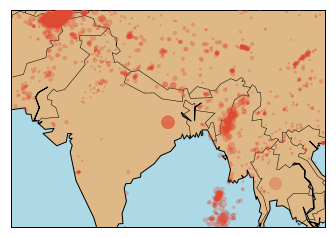

/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [114]:
plot_earthquakes(res)
